In [1]:
# MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# IMPORT ESSENTIAL LIBRARIES
import os
import numpy as np
from osgeo import gdal
# import gdal
import keras
import tensorflow as tf
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure
from google.colab import drive
from sklearn.metrics import confusion_matrix

Populating the interactive namespace from numpy and matplotlib


In [3]:
# IMPORTING THE ESSENTIAL LIBRARIES FOR SEGNET
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [4]:
# DEFINING A FUNCTION FOR "recall_m"
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# DEFINING A FUNCTION FOR "precision_m"
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# DEFININF A FUNCTION FOR "f1_m"
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# DEFINING A FUNCTION FOR CALCULATING JACARD COEFFICIENT
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [22]:
import numpy as np
from osgeo import gdal
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image

# Set the patch size and stride
patch_size = 256
stride = 128
 
# Load the test image
test_image_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/GROUND_TRUTH_LC/RASTER_10.tif"
test_image = gdal.Open(test_image_path)
test_image_array = np.transpose(test_image.ReadAsArray(), (1, 2, 0))

# Compute the number of patches in each dimension
num_patches_x = int(np.ceil((test_image_array.shape[0] - patch_size) / stride)) + 1
num_patches_y = int(np.ceil((test_image_array.shape[1] - patch_size) / stride)) + 1
num_patches = num_patches_x * num_patches_y

# Create an array to store the predicted patches
predicted_patches = np.zeros((num_patches, patch_size, patch_size, 8))

# Load the trained model
model_path = "/content/drive/MyDrive/DEEP_LEARNING/TRAINED_MODEL/LAND_COVER/SEGNET_Weights_Improvement_181_0.72.hdf5"
model = load_model(model_path, compile=False)

# Perform predictions on each patch
for i in range(num_patches_x):
    for j in range(num_patches_y):
        # Compute the coordinates of the patch
        x1 = i * stride
        y1 = j * stride
        x2 = x1 + patch_size
        y2 = y1 + patch_size

        # Extract the patch and transpose it to have the channel dimension as the last axis
        patch = test_image_array[x1:x2, y1:y2, :]

        # Perform prediction on the patch
        prediction = model.predict(np.expand_dims(patch, axis=0))

        # Store the predicted patch
        predicted_patches[i*num_patches_y+j, :, :, :] = prediction[0]

# Reshape predicted patches array into a 3D array with the same shape as the original test image
predicted_image_array = np.zeros((test_image_array.shape[0], test_image_array.shape[1], 8))
count_array = np.zeros((test_image_array.shape[0], test_image_array.shape[1]))
for i in range(num_patches_x):
    for j in range(num_patches_y):
        # Compute the coordinates of the patch
        x1 = i * stride
        y1 = j * stride
        x2 = x1 + patch_size
        y2 = y1 + patch_size

        # Add the predicted patch to the predicted image
        predicted_image_array[x1:x2, y1:y2, :] += predicted_patches[i*num_patches_y+j, :, :, :]
        count_array[x1:x2, y1:y2] += 1

# Compute the mean of the predicted patches where the count is non-zero
predicted_image_array = predicted_image_array / np.expand_dims(count_array, axis=-1)

# # Convert the predicted image array to an RGB image
# predicted_image = Image.fromarray(np.uint8(predicted_image_array.argmax(axis=-1)))

# # Plot the predicted image
# plt.imshow(predicted_image)
# plt.show()

1/1 [==============================] - 0s 20ms/step


In [23]:
# Load the ground truth image
ground_truth_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/LABEL_LC/RASTER_10.tif"
ground_truth_image = gdal.Open(ground_truth_path)
ground_truth_array = ground_truth_image.ReadAsArray()

# # Map ground truth class indices to match predicted class indices
# mapping = {10: 0, 20: 1, 30: 2, 40: 3, 50: 4, 60: 5, 80: 6, 90: 7}
# map_ground_truth = np.vectorize(mapping.get)
# ground_truth_array_mapped = map_ground_truth(ground_truth_array)

# Get predicted class indices from one-hot encoded array
predicted_class_indices = np.argmax(predicted_image_array, axis=-1)

# Map predicted class indices to original values
mapping_reverse = {0: 10, 1: 20, 2: 30, 3: 40, 4: 50, 5: 60, 6: 80, 7: 90}
map_predicted = np.vectorize(mapping_reverse.get)
predicted_class_indices_mapped = map_predicted(predicted_class_indices)

# Flatenning both the Ground Truth Labels and the Predictions 
ground_truth_array_flat = ground_truth_array.flatten()
predicted_class_indices_mapped_flat = predicted_class_indices_mapped.flatten()

# Get predicted class indices from one-hot encoded array
predicted_class_indices = np.argmax(predicted_image_array, axis=-1)

# Map predicted class indices to original values
mapping_reverse = {0: 10, 1: 20, 2: 30, 3: 40, 4: 50, 5: 60, 6: 80, 7: 90}
map_predicted = np.vectorize(mapping_reverse.get)
predicted_class_indices_mapped = map_predicted(predicted_class_indices)

confusion_mtx = confusion_matrix(ground_truth_array_flat, predicted_class_indices_mapped_flat, labels=[10, 20, 30, 40, 50, 60, 80, 90])

# Create a dictionary to map class numbers to labels
class_labels = {
    10: "Tree Cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-Up",
    60: "Bare / Sparse Vegetation",
    80: "Permanent Water Bodies",
    90: "Herbaceous Wetland",
}

# Overall accuracy
overall_accuracy = np.sum(np.diag(confusion_mtx)) / np.sum(confusion_mtx)
print("Overall Accuracy:", overall_accuracy)

print("\n")
print("Producer Accuracy")

# Producer's accuracy (per class)
producer_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
for i, class_number in enumerate([10, 20, 30, 40, 50, 60, 80, 90]):
    print(f"{class_labels[class_number]} : {producer_accuracy[i]}")

print("\n")
print("User Accuracy")

# User's accuracy (per class)
user_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=0)
for i, class_number in enumerate([10, 20, 30, 40, 50, 60, 80, 90]):
    print(f"{class_labels[class_number]} : {user_accuracy[i]}")

Overall Accuracy: 0.4674230045542149


Producer Accuracy
Tree Cover : 0.5244622245540399
Shrubland : 0.20048890437509528
Grassland : 0.9040432836334864
Cropland : 0.07283375355485906
Built-Up : 0.21142373427926475
Bare / Sparse Vegetation : 0.04693802713604694
Permanent Water Bodies : 0.6595238095238095
Herbaceous Wetland : 0.3318959592073592


User Accuracy
Tree Cover : 0.024541942057243048
Shrubland : 0.5849593234569955
Grassland : 0.42638131955435243
Cropland : 0.4017318501188321
Built-Up : 0.787655804174801
Bare / Sparse Vegetation : 0.44755244755244755
Permanent Water Bodies : 0.20874152223059533
Herbaceous Wetland : 0.7824714595596528


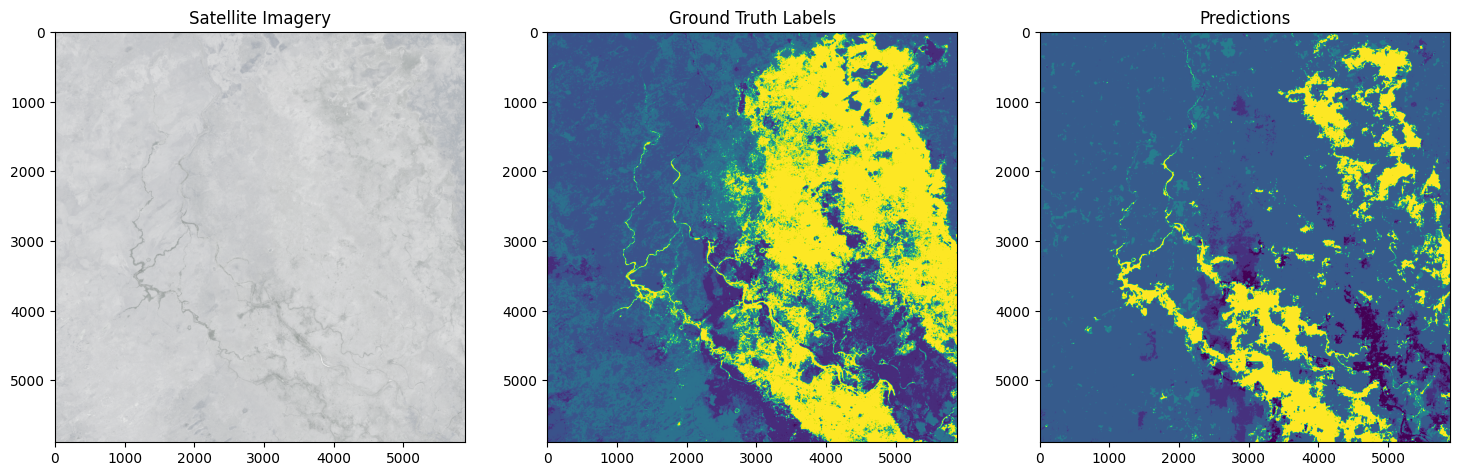

In [24]:
# Load the satellite imagery
satellite_image_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/GROUND_TRUTH_LC/RASTER_10.tif"
satellite_image = gdal.Open(satellite_image_path)
satellite_image_array = np.transpose(satellite_image.ReadAsArray(), (1, 2, 0))

# Load the ground truth labels
ground_truth_labels_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/LABEL_LC/RASTER_10.tif"
ground_truth_labels = gdal.Open(ground_truth_labels_path)
ground_truth_labels_array = ground_truth_labels.ReadAsArray()

# Convert the predicted image array to an RGB image
predicted_image_array_rgb = predicted_image_array.argmax(axis=-1)

# Plot Satellite Imagery, Ground Truth Labels, and Predictions together
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(satellite_image_array)
ax[0].set_title('Satellite Imagery')

ax[1].imshow(ground_truth_labels_array)
ax[1].set_title('Ground Truth Labels')

ax[2].imshow(predicted_image_array_rgb)
ax[2].set_title('Predictions')

plt.show()

In [25]:
import numpy as np
from osgeo import gdal
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image

# Set the patch size and stride
patch_size = 256
stride = 128
 
# Load the test image
test_image_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/GROUND_TRUTH_LC/RASTER_12.tif"
test_image = gdal.Open(test_image_path)
test_image_array = np.transpose(test_image.ReadAsArray(), (1, 2, 0))

# Compute the number of patches in each dimension
num_patches_x = int(np.ceil((test_image_array.shape[0] - patch_size) / stride)) + 1
num_patches_y = int(np.ceil((test_image_array.shape[1] - patch_size) / stride)) + 1
num_patches = num_patches_x * num_patches_y

# Create an array to store the predicted patches
predicted_patches = np.zeros((num_patches, patch_size, patch_size, 8))

# Load the trained model
model_path = "/content/drive/MyDrive/DEEP_LEARNING/TRAINED_MODEL/LAND_COVER/SEGNET_Weights_Improvement_181_0.72.hdf5"
model = load_model(model_path, compile=False)

# Perform predictions on each patch
for i in range(num_patches_x):
    for j in range(num_patches_y):
        # Compute the coordinates of the patch
        x1 = i * stride
        y1 = j * stride
        x2 = x1 + patch_size
        y2 = y1 + patch_size

        # Extract the patch and transpose it to have the channel dimension as the last axis
        patch = test_image_array[x1:x2, y1:y2, :]

        # Perform prediction on the patch
        prediction = model.predict(np.expand_dims(patch, axis=0))

        # Store the predicted patch
        predicted_patches[i*num_patches_y+j, :, :, :] = prediction[0]

# Reshape predicted patches array into a 3D array with the same shape as the original test image
predicted_image_array = np.zeros((test_image_array.shape[0], test_image_array.shape[1], 8))
count_array = np.zeros((test_image_array.shape[0], test_image_array.shape[1]))
for i in range(num_patches_x):
    for j in range(num_patches_y):
        # Compute the coordinates of the patch
        x1 = i * stride
        y1 = j * stride
        x2 = x1 + patch_size
        y2 = y1 + patch_size

        # Add the predicted patch to the predicted image
        predicted_image_array[x1:x2, y1:y2, :] += predicted_patches[i*num_patches_y+j, :, :, :]
        count_array[x1:x2, y1:y2] += 1

# Compute the mean of the predicted patches where the count is non-zero
predicted_image_array = predicted_image_array / np.expand_dims(count_array, axis=-1)

# # Convert the predicted image array to an RGB image
# predicted_image = Image.fromarray(np.uint8(predicted_image_array.argmax(axis=-1)))

# # Plot the predicted image
# plt.imshow(predicted_image)
# plt.show()

1/1 [==============================] - 0s 22ms/step


In [26]:
# Load the ground truth image
ground_truth_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/LABEL_LC/RASTER_12.tif"
ground_truth_image = gdal.Open(ground_truth_path)
ground_truth_array = ground_truth_image.ReadAsArray()

# # Map ground truth class indices to match predicted class indices
# mapping = {10: 0, 20: 1, 30: 2, 40: 3, 50: 4, 60: 5, 80: 6, 90: 7}
# map_ground_truth = np.vectorize(mapping.get)
# ground_truth_array_mapped = map_ground_truth(ground_truth_array)

# Get predicted class indices from one-hot encoded array
predicted_class_indices = np.argmax(predicted_image_array, axis=-1)

# Map predicted class indices to original values
mapping_reverse = {0: 10, 1: 20, 2: 30, 3: 40, 4: 50, 5: 60, 6: 80, 7: 90}
map_predicted = np.vectorize(mapping_reverse.get)
predicted_class_indices_mapped = map_predicted(predicted_class_indices)

# Flatenning both the Ground Truth Labels and the Predictions 
ground_truth_array_flat = ground_truth_array.flatten()
predicted_class_indices_mapped_flat = predicted_class_indices_mapped.flatten()

# Get predicted class indices from one-hot encoded array
predicted_class_indices = np.argmax(predicted_image_array, axis=-1)

# Map predicted class indices to original values
mapping_reverse = {0: 10, 1: 20, 2: 30, 3: 40, 4: 50, 5: 60, 6: 80, 7: 90}
map_predicted = np.vectorize(mapping_reverse.get)
predicted_class_indices_mapped = map_predicted(predicted_class_indices)

confusion_mtx = confusion_matrix(ground_truth_array_flat, predicted_class_indices_mapped_flat, labels=[10, 20, 30, 40, 50, 60, 80, 90])

# Create a dictionary to map class numbers to labels
class_labels = {
    10: "Tree Cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-Up",
    60: "Bare / Sparse Vegetation",
    80: "Permanent Water Bodies",
    90: "Herbaceous Wetland",
}

# Overall accuracy
overall_accuracy = np.sum(np.diag(confusion_mtx)) / np.sum(confusion_mtx)
print("Overall Accuracy:", overall_accuracy)

print("\n")
print("Producer Accuracy")

# Producer's accuracy (per class)
producer_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
for i, class_number in enumerate([10, 20, 30, 40, 50, 60, 80, 90]):
    print(f"{class_labels[class_number]} : {producer_accuracy[i]}")

print("\n")
print("User Accuracy")

# User's accuracy (per class)
user_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=0)
for i, class_number in enumerate([10, 20, 30, 40, 50, 60, 80, 90]):
    print(f"{class_labels[class_number]} : {user_accuracy[i]}")

Overall Accuracy: 0.7030365047923559


Producer Accuracy
Tree Cover : 0.36402829810667187
Shrubland : 0.3721540756369357
Grassland : 0.9128840304313244
Cropland : 0.27698585749429094
Built-Up : 0.6141679036780472
Bare / Sparse Vegetation : 0.2616348846512868
Permanent Water Bodies : 0.7560975609756098
Herbaceous Wetland : 0.0011135857461024498


User Accuracy
Tree Cover : 0.7833644313769836
Shrubland : 0.6364079740747656
Grassland : 0.7237676553164076
Cropland : 0.564984364736441
Built-Up : 0.902376076868086
Bare / Sparse Vegetation : 0.4479963466149104
Permanent Water Bodies : 0.14650283553875237
Herbaceous Wetland : 3.856437679967092e-05


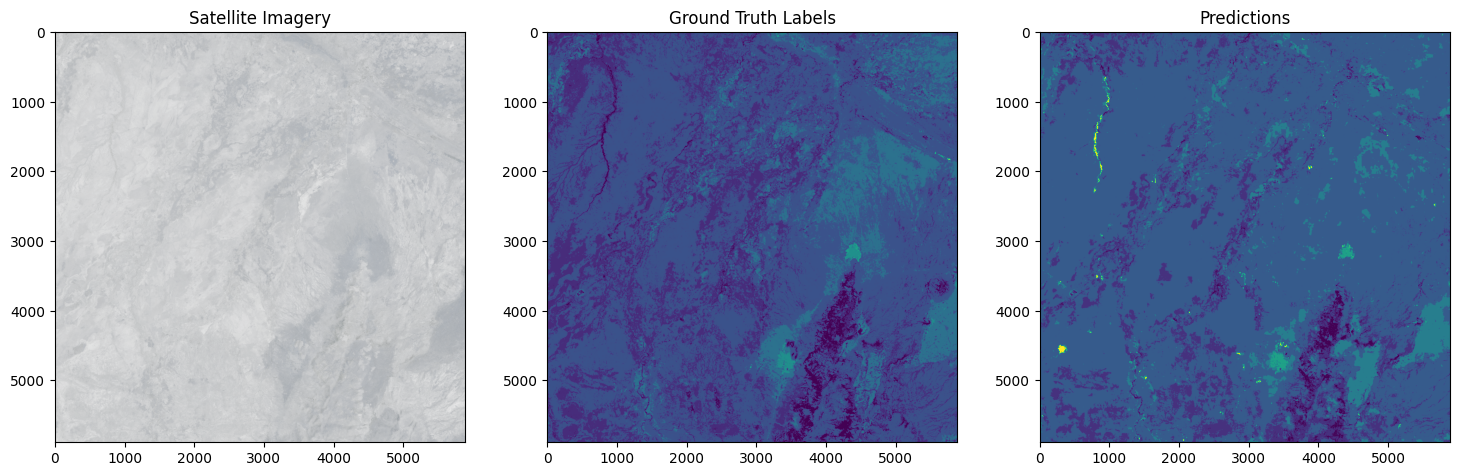

In [27]:
# Load the satellite imagery
satellite_image_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/GROUND_TRUTH_LC/RASTER_12.tif"
satellite_image = gdal.Open(satellite_image_path)
satellite_image_array = np.transpose(satellite_image.ReadAsArray(), (1, 2, 0))

# Load the ground truth labels
ground_truth_labels_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/LABEL_LC/RASTER_12.tif"
ground_truth_labels = gdal.Open(ground_truth_labels_path)
ground_truth_labels_array = ground_truth_labels.ReadAsArray()

# Convert the predicted image array to an RGB image
predicted_image_array_rgb = predicted_image_array.argmax(axis=-1)

# Plot Satellite Imagery, Ground Truth Labels, and Predictions together
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(satellite_image_array)
ax[0].set_title('Satellite Imagery')

ax[1].imshow(ground_truth_labels_array)
ax[1].set_title('Ground Truth Labels')

ax[2].imshow(predicted_image_array_rgb)
ax[2].set_title('Predictions')

plt.show()

In [28]:
import numpy as np
from osgeo import gdal
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image

# Set the patch size and stride
patch_size = 256
stride = 128
 
# Load the test image
test_image_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/GROUND_TRUTH_LC/RASTER_13.tif"
test_image = gdal.Open(test_image_path)
test_image_array = np.transpose(test_image.ReadAsArray(), (1, 2, 0))

# Compute the number of patches in each dimension
num_patches_x = int(np.ceil((test_image_array.shape[0] - patch_size) / stride)) + 1
num_patches_y = int(np.ceil((test_image_array.shape[1] - patch_size) / stride)) + 1
num_patches = num_patches_x * num_patches_y

# Create an array to store the predicted patches
predicted_patches = np.zeros((num_patches, patch_size, patch_size, 8))

# Load the trained model
model_path = "/content/drive/MyDrive/DEEP_LEARNING/TRAINED_MODEL/LAND_COVER/SEGNET_Weights_Improvement_181_0.72.hdf5"
model = load_model(model_path, compile=False)

# Perform predictions on each patch
for i in range(num_patches_x):
    for j in range(num_patches_y):
        # Compute the coordinates of the patch
        x1 = i * stride
        y1 = j * stride
        x2 = x1 + patch_size
        y2 = y1 + patch_size

        # Extract the patch and transpose it to have the channel dimension as the last axis
        patch = test_image_array[x1:x2, y1:y2, :]

        # Perform prediction on the patch
        prediction = model.predict(np.expand_dims(patch, axis=0))

        # Store the predicted patch
        predicted_patches[i*num_patches_y+j, :, :, :] = prediction[0]

# Reshape predicted patches array into a 3D array with the same shape as the original test image
predicted_image_array = np.zeros((test_image_array.shape[0], test_image_array.shape[1], 8))
count_array = np.zeros((test_image_array.shape[0], test_image_array.shape[1]))
for i in range(num_patches_x):
    for j in range(num_patches_y):
        # Compute the coordinates of the patch
        x1 = i * stride
        y1 = j * stride
        x2 = x1 + patch_size
        y2 = y1 + patch_size

        # Add the predicted patch to the predicted image
        predicted_image_array[x1:x2, y1:y2, :] += predicted_patches[i*num_patches_y+j, :, :, :]
        count_array[x1:x2, y1:y2] += 1

# Compute the mean of the predicted patches where the count is non-zero
predicted_image_array = predicted_image_array / np.expand_dims(count_array, axis=-1)

# # Convert the predicted image array to an RGB image
# predicted_image = Image.fromarray(np.uint8(predicted_image_array.argmax(axis=-1)))

# # Plot the predicted image
# plt.imshow(predicted_image)
# plt.show()

1/1 [==============================] - 0s 20ms/step


In [29]:
# Load the ground truth image
ground_truth_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/LABEL_LC/RASTER_13.tif"
ground_truth_image = gdal.Open(ground_truth_path)
ground_truth_array = ground_truth_image.ReadAsArray()

# # Map ground truth class indices to match predicted class indices
# mapping = {10: 0, 20: 1, 30: 2, 40: 3, 50: 4, 60: 5, 80: 6, 90: 7}
# map_ground_truth = np.vectorize(mapping.get)
# ground_truth_array_mapped = map_ground_truth(ground_truth_array)

# Get predicted class indices from one-hot encoded array
predicted_class_indices = np.argmax(predicted_image_array, axis=-1)

# Map predicted class indices to original values
mapping_reverse = {0: 10, 1: 20, 2: 30, 3: 40, 4: 50, 5: 60, 6: 80, 7: 90}
map_predicted = np.vectorize(mapping_reverse.get)
predicted_class_indices_mapped = map_predicted(predicted_class_indices)

# Flatenning both the Ground Truth Labels and the Predictions 
ground_truth_array_flat = ground_truth_array.flatten()
predicted_class_indices_mapped_flat = predicted_class_indices_mapped.flatten()

# Get predicted class indices from one-hot encoded array
predicted_class_indices = np.argmax(predicted_image_array, axis=-1)

# Map predicted class indices to original values
mapping_reverse = {0: 10, 1: 20, 2: 30, 3: 40, 4: 50, 5: 60, 6: 80, 7: 90}
map_predicted = np.vectorize(mapping_reverse.get)
predicted_class_indices_mapped = map_predicted(predicted_class_indices)

confusion_mtx = confusion_matrix(ground_truth_array_flat, predicted_class_indices_mapped_flat, labels=[10, 20, 30, 40, 50, 60, 80, 90])

# Create a dictionary to map class numbers to labels
class_labels = {
    10: "Tree Cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-Up",
    60: "Bare / Sparse Vegetation",
    80: "Permanent Water Bodies",
    90: "Herbaceous Wetland",
}

# Overall accuracy
overall_accuracy = np.sum(np.diag(confusion_mtx)) / np.sum(confusion_mtx)
print("Overall Accuracy:", overall_accuracy)

print("\n")
print("Producer Accuracy")

# Producer's accuracy (per class)
producer_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
for i, class_number in enumerate([10, 20, 30, 40, 50, 60, 80, 90]):
    print(f"{class_labels[class_number]} : {producer_accuracy[i]}")

print("\n")
print("User Accuracy")

# User's accuracy (per class)
user_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=0)
for i, class_number in enumerate([10, 20, 30, 40, 50, 60, 80, 90]):
    print(f"{class_labels[class_number]} : {user_accuracy[i]}")

Overall Accuracy: 0.6117347183660208


Producer Accuracy
Tree Cover : 0.6407726948457285
Shrubland : 0.46003358194384786
Grassland : 0.7420276235293028
Cropland : 0.38673309123230765
Built-Up : 0.5709539968265477
Bare / Sparse Vegetation : 0.45900044890019454
Permanent Water Bodies : 0.07335640138408304
Herbaceous Wetland : 0.24258768918963095


User Accuracy
Tree Cover : 0.31539069272382125
Shrubland : 0.5449125480241475
Grassland : 0.6892029130197709
Cropland : 0.4513508995998735
Built-Up : 0.8661413773518567
Bare / Sparse Vegetation : 0.4359308384651824
Permanent Water Bodies : 0.4854961832061069
Herbaceous Wetland : 0.13433295118566344


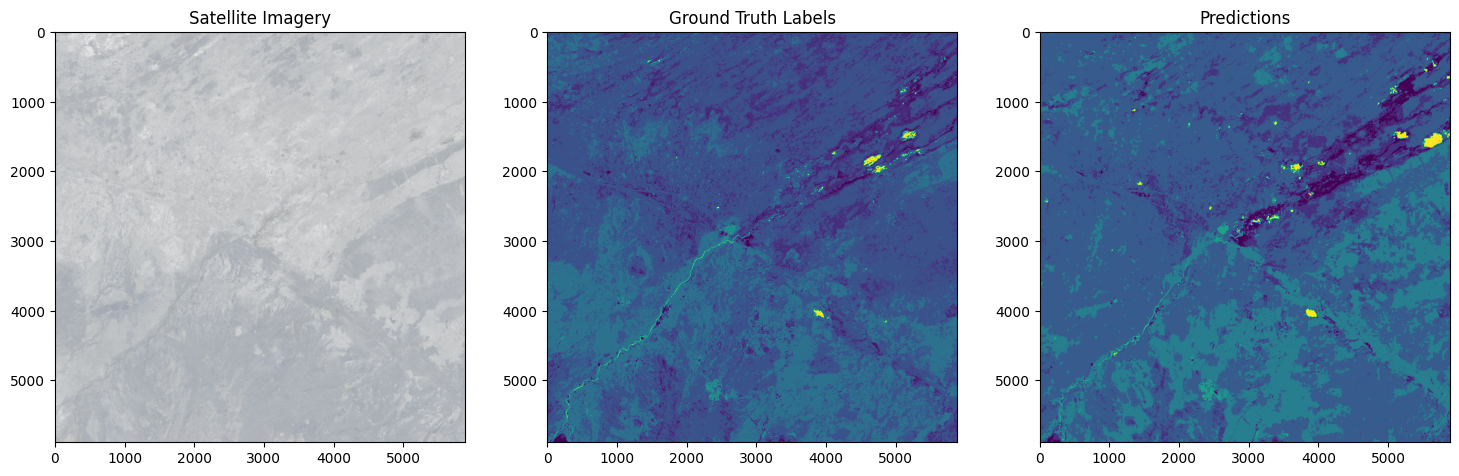

In [30]:
# Load the satellite imagery
satellite_image_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/GROUND_TRUTH_LC/RASTER_13.tif"
satellite_image = gdal.Open(satellite_image_path)
satellite_image_array = np.transpose(satellite_image.ReadAsArray(), (1, 2, 0))

# Load the ground truth labels
ground_truth_labels_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/LABEL_LC/RASTER_13.tif"
ground_truth_labels = gdal.Open(ground_truth_labels_path)
ground_truth_labels_array = ground_truth_labels.ReadAsArray()

# Convert the predicted image array to an RGB image
predicted_image_array_rgb = predicted_image_array.argmax(axis=-1)

# Plot Satellite Imagery, Ground Truth Labels, and Predictions together
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(satellite_image_array)
ax[0].set_title('Satellite Imagery')

ax[1].imshow(ground_truth_labels_array)
ax[1].set_title('Ground Truth Labels')

ax[2].imshow(predicted_image_array_rgb)
ax[2].set_title('Predictions')

plt.show()

In [31]:
import numpy as np
from osgeo import gdal
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image

# Set the patch size and stride
patch_size = 256
stride = 128
 
# Load the test image
test_image_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/GROUND_TRUTH_LC/RASTER_15.tif"
test_image = gdal.Open(test_image_path)
test_image_array = np.transpose(test_image.ReadAsArray(), (1, 2, 0))

# Compute the number of patches in each dimension
num_patches_x = int(np.ceil((test_image_array.shape[0] - patch_size) / stride)) + 1
num_patches_y = int(np.ceil((test_image_array.shape[1] - patch_size) / stride)) + 1
num_patches = num_patches_x * num_patches_y

# Create an array to store the predicted patches
predicted_patches = np.zeros((num_patches, patch_size, patch_size, 8))

# Load the trained model
model_path = "/content/drive/MyDrive/DEEP_LEARNING/TRAINED_MODEL/LAND_COVER/SEGNET_Weights_Improvement_181_0.72.hdf5"
model = load_model(model_path, compile=False)

# Perform predictions on each patch
for i in range(num_patches_x):
    for j in range(num_patches_y):
        # Compute the coordinates of the patch
        x1 = i * stride
        y1 = j * stride
        x2 = x1 + patch_size
        y2 = y1 + patch_size

        # Extract the patch and transpose it to have the channel dimension as the last axis
        patch = test_image_array[x1:x2, y1:y2, :]

        # Perform prediction on the patch
        prediction = model.predict(np.expand_dims(patch, axis=0))

        # Store the predicted patch
        predicted_patches[i*num_patches_y+j, :, :, :] = prediction[0]

# Reshape predicted patches array into a 3D array with the same shape as the original test image
predicted_image_array = np.zeros((test_image_array.shape[0], test_image_array.shape[1], 8))
count_array = np.zeros((test_image_array.shape[0], test_image_array.shape[1]))
for i in range(num_patches_x):
    for j in range(num_patches_y):
        # Compute the coordinates of the patch
        x1 = i * stride
        y1 = j * stride
        x2 = x1 + patch_size
        y2 = y1 + patch_size

        # Add the predicted patch to the predicted image
        predicted_image_array[x1:x2, y1:y2, :] += predicted_patches[i*num_patches_y+j, :, :, :]
        count_array[x1:x2, y1:y2] += 1

# Compute the mean of the predicted patches where the count is non-zero
predicted_image_array = predicted_image_array / np.expand_dims(count_array, axis=-1)

# # Convert the predicted image array to an RGB image
# predicted_image = Image.fromarray(np.uint8(predicted_image_array.argmax(axis=-1)))

# # Plot the predicted image
# plt.imshow(predicted_image)
# plt.show()

1/1 [==============================] - 0s 20ms/step


In [32]:
# Load the ground truth image
ground_truth_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/LABEL_LC/RASTER_15.tif"
ground_truth_image = gdal.Open(ground_truth_path)
ground_truth_array = ground_truth_image.ReadAsArray()

# # Map ground truth class indices to match predicted class indices
# mapping = {10: 0, 20: 1, 30: 2, 40: 3, 50: 4, 60: 5, 80: 6, 90: 7}
# map_ground_truth = np.vectorize(mapping.get)
# ground_truth_array_mapped = map_ground_truth(ground_truth_array)

# Get predicted class indices from one-hot encoded array
predicted_class_indices = np.argmax(predicted_image_array, axis=-1)

# Map predicted class indices to original values
mapping_reverse = {0: 10, 1: 20, 2: 30, 3: 40, 4: 50, 5: 60, 6: 80, 7: 90}
map_predicted = np.vectorize(mapping_reverse.get)
predicted_class_indices_mapped = map_predicted(predicted_class_indices)

# Flatenning both the Ground Truth Labels and the Predictions 
ground_truth_array_flat = ground_truth_array.flatten()
predicted_class_indices_mapped_flat = predicted_class_indices_mapped.flatten()

# Get predicted class indices from one-hot encoded array
predicted_class_indices = np.argmax(predicted_image_array, axis=-1)

# Map predicted class indices to original values
mapping_reverse = {0: 10, 1: 20, 2: 30, 3: 40, 4: 50, 5: 60, 6: 80, 7: 90}
map_predicted = np.vectorize(mapping_reverse.get)
predicted_class_indices_mapped = map_predicted(predicted_class_indices)

confusion_mtx = confusion_matrix(ground_truth_array_flat, predicted_class_indices_mapped_flat, labels=[10, 20, 30, 40, 50, 60, 80, 90])

# Create a dictionary to map class numbers to labels
class_labels = {
    10: "Tree Cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-Up",
    60: "Bare / Sparse Vegetation",
    80: "Permanent Water Bodies",
    90: "Herbaceous Wetland",
}

# Overall accuracy
overall_accuracy = np.sum(np.diag(confusion_mtx)) / np.sum(confusion_mtx)
print("Overall Accuracy:", overall_accuracy)

print("\n")
print("Producer Accuracy")

# Producer's accuracy (per class)
producer_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
for i, class_number in enumerate([10, 20, 30, 40, 50, 60, 80, 90]):
    print(f"{class_labels[class_number]} : {producer_accuracy[i]}")

print("\n")
print("User Accuracy")

# User's accuracy (per class)
user_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=0)
for i, class_number in enumerate([10, 20, 30, 40, 50, 60, 80, 90]):
    print(f"{class_labels[class_number]} : {user_accuracy[i]}")

Overall Accuracy: 0.5643343141263735


Producer Accuracy
Tree Cover : 0.5093514852158768
Shrubland : 0.590694192304929
Grassland : 0.5956298411075421
Cropland : 0.3739540954789114
Built-Up : 0.3479870983156134
Bare / Sparse Vegetation : 0.16533116948980628
Permanent Water Bodies : 0.962824387985731
Herbaceous Wetland : 0.5599456106740669


User Accuracy
Tree Cover : 0.3557941811061791
Shrubland : 0.6260239751504333
Grassland : 0.4417419699949627
Cropland : 0.22266659219997897
Built-Up : 0.7343450640314612
Bare / Sparse Vegetation : 0.2714404662781016
Permanent Water Bodies : 0.8919037545026789
Herbaceous Wetland : 0.9087921217525206


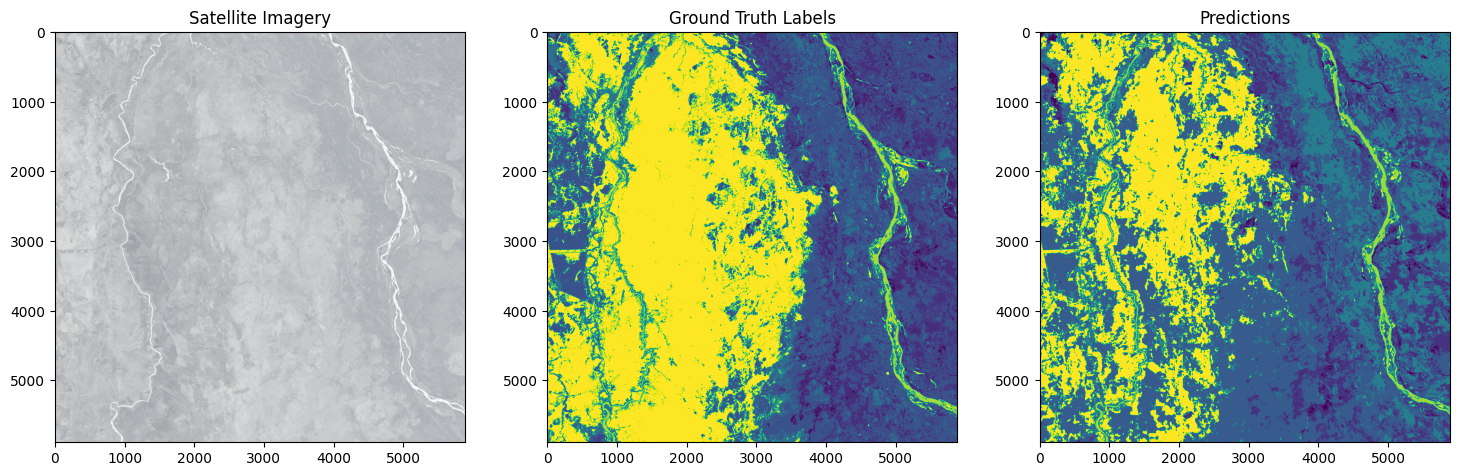

In [33]:
# Load the satellite imagery
satellite_image_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/GROUND_TRUTH_LC/RASTER_15.tif"
satellite_image = gdal.Open(satellite_image_path)
satellite_image_array = np.transpose(satellite_image.ReadAsArray(), (1, 2, 0))

# Load the ground truth labels
ground_truth_labels_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/LABEL_LC/RASTER_15.tif"
ground_truth_labels = gdal.Open(ground_truth_labels_path)
ground_truth_labels_array = ground_truth_labels.ReadAsArray()

# Convert the predicted image array to an RGB image
predicted_image_array_rgb = predicted_image_array.argmax(axis=-1)

# Plot Satellite Imagery, Ground Truth Labels, and Predictions together
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(satellite_image_array)
ax[0].set_title('Satellite Imagery')

ax[1].imshow(ground_truth_labels_array)
ax[1].set_title('Ground Truth Labels')

ax[2].imshow(predicted_image_array_rgb)
ax[2].set_title('Predictions')

plt.show()

In [34]:
import numpy as np
from osgeo import gdal
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image

# Set the patch size and stride
patch_size = 256
stride = 128
 
# Load the test image
test_image_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/GROUND_TRUTH_LC/RASTER_18.tif"
test_image = gdal.Open(test_image_path)
test_image_array = np.transpose(test_image.ReadAsArray(), (1, 2, 0))

# Compute the number of patches in each dimension
num_patches_x = int(np.ceil((test_image_array.shape[0] - patch_size) / stride)) + 1
num_patches_y = int(np.ceil((test_image_array.shape[1] - patch_size) / stride)) + 1
num_patches = num_patches_x * num_patches_y

# Create an array to store the predicted patches
predicted_patches = np.zeros((num_patches, patch_size, patch_size, 8))

# Load the trained model
model_path = "/content/drive/MyDrive/DEEP_LEARNING/TRAINED_MODEL/LAND_COVER/SEGNET_Weights_Improvement_181_0.72.hdf5"
model = load_model(model_path, compile=False)

# Perform predictions on each patch
for i in range(num_patches_x):
    for j in range(num_patches_y):
        # Compute the coordinates of the patch
        x1 = i * stride
        y1 = j * stride
        x2 = x1 + patch_size
        y2 = y1 + patch_size

        # Extract the patch and transpose it to have the channel dimension as the last axis
        patch = test_image_array[x1:x2, y1:y2, :]

        # Perform prediction on the patch
        prediction = model.predict(np.expand_dims(patch, axis=0))

        # Store the predicted patch
        predicted_patches[i*num_patches_y+j, :, :, :] = prediction[0]

# Reshape predicted patches array into a 3D array with the same shape as the original test image
predicted_image_array = np.zeros((test_image_array.shape[0], test_image_array.shape[1], 8))
count_array = np.zeros((test_image_array.shape[0], test_image_array.shape[1]))
for i in range(num_patches_x):
    for j in range(num_patches_y):
        # Compute the coordinates of the patch
        x1 = i * stride
        y1 = j * stride
        x2 = x1 + patch_size
        y2 = y1 + patch_size

        # Add the predicted patch to the predicted image
        predicted_image_array[x1:x2, y1:y2, :] += predicted_patches[i*num_patches_y+j, :, :, :]
        count_array[x1:x2, y1:y2] += 1

# Compute the mean of the predicted patches where the count is non-zero
predicted_image_array = predicted_image_array / np.expand_dims(count_array, axis=-1)

# # Convert the predicted image array to an RGB image
# predicted_image = Image.fromarray(np.uint8(predicted_image_array.argmax(axis=-1)))

# # Plot the predicted image
# plt.imshow(predicted_image)
# plt.show()

1/1 [==============================] - 0s 24ms/step


In [35]:
# Load the ground truth image
ground_truth_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/LABEL_LC/RASTER_18.tif"
ground_truth_image = gdal.Open(ground_truth_path)
ground_truth_array = ground_truth_image.ReadAsArray()

# # Map ground truth class indices to match predicted class indices
# mapping = {10: 0, 20: 1, 30: 2, 40: 3, 50: 4, 60: 5, 80: 6, 90: 7}
# map_ground_truth = np.vectorize(mapping.get)
# ground_truth_array_mapped = map_ground_truth(ground_truth_array)

# Get predicted class indices from one-hot encoded array
predicted_class_indices = np.argmax(predicted_image_array, axis=-1)

# Map predicted class indices to original values
mapping_reverse = {0: 10, 1: 20, 2: 30, 3: 40, 4: 50, 5: 60, 6: 80, 7: 90}
map_predicted = np.vectorize(mapping_reverse.get)
predicted_class_indices_mapped = map_predicted(predicted_class_indices)

# Flatenning both the Ground Truth Labels and the Predictions 
ground_truth_array_flat = ground_truth_array.flatten()
predicted_class_indices_mapped_flat = predicted_class_indices_mapped.flatten()

# Get predicted class indices from one-hot encoded array
predicted_class_indices = np.argmax(predicted_image_array, axis=-1)

# Map predicted class indices to original values
mapping_reverse = {0: 10, 1: 20, 2: 30, 3: 40, 4: 50, 5: 60, 6: 80, 7: 90}
map_predicted = np.vectorize(mapping_reverse.get)
predicted_class_indices_mapped = map_predicted(predicted_class_indices)

confusion_mtx = confusion_matrix(ground_truth_array_flat, predicted_class_indices_mapped_flat, labels=[10, 20, 30, 40, 50, 60, 80, 90])

# Create a dictionary to map class numbers to labels
class_labels = {
    10: "Tree Cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-Up",
    60: "Bare / Sparse Vegetation",
    80: "Permanent Water Bodies",
    90: "Herbaceous Wetland",
}

# Overall accuracy
overall_accuracy = np.sum(np.diag(confusion_mtx)) / np.sum(confusion_mtx)
print("Overall Accuracy:", overall_accuracy)

print("\n")
print("Producer Accuracy")

# Producer's accuracy (per class)
producer_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
for i, class_number in enumerate([10, 20, 30, 40, 50, 60, 80, 90]):
    print(f"{class_labels[class_number]} : {producer_accuracy[i]}")

print("\n")
print("User Accuracy")

# User's accuracy (per class)
user_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=0)
for i, class_number in enumerate([10, 20, 30, 40, 50, 60, 80, 90]):
    print(f"{class_labels[class_number]} : {user_accuracy[i]}")

Overall Accuracy: 0.5720227823816311


Producer Accuracy
Tree Cover : 0.6097202702810002
Shrubland : 0.6364015639380216
Grassland : 0.683227848388513
Cropland : 0.39747691573885574
Built-Up : 0.5212802352581507
Bare / Sparse Vegetation : 0.30926843859499187
Permanent Water Bodies : 0.9717071467195386
Herbaceous Wetland : 0.6672719156941378


User Accuracy
Tree Cover : 0.3945718748715419
Shrubland : 0.8561524098912129
Grassland : 0.490228421677929
Cropland : 0.5441117638445532
Built-Up : 0.821553533939818
Bare / Sparse Vegetation : 0.6122060565048215
Permanent Water Bodies : 0.8978879103949368
Herbaceous Wetland : 0.815079154855932


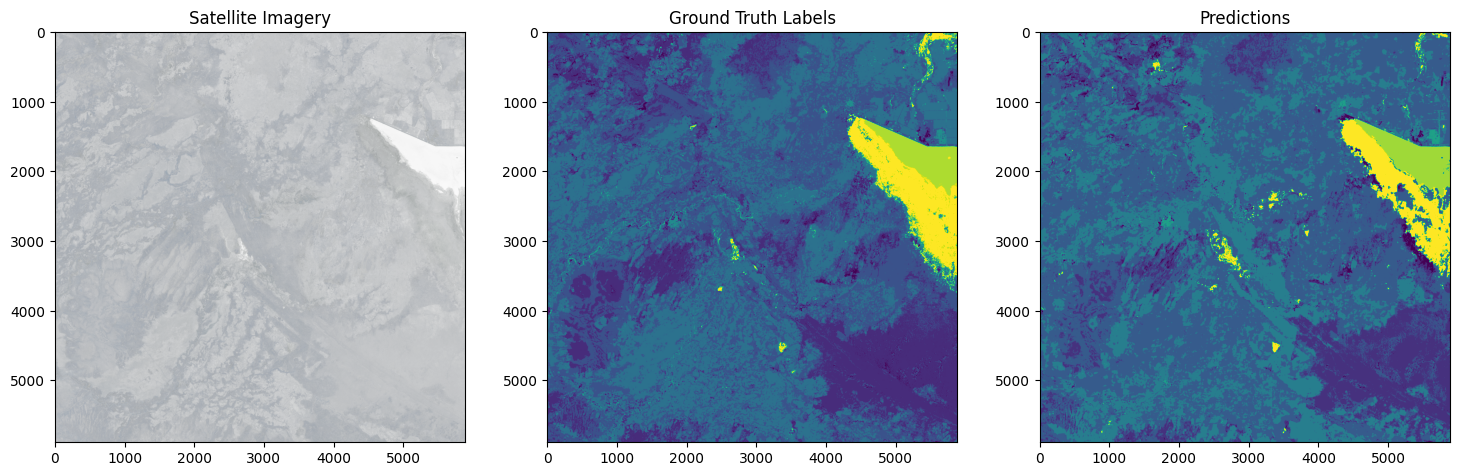

In [36]:
# Load the satellite imagery
satellite_image_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/GROUND_TRUTH_LC/RASTER_18.tif"
satellite_image = gdal.Open(satellite_image_path)
satellite_image_array = np.transpose(satellite_image.ReadAsArray(), (1, 2, 0))

# Load the ground truth labels
ground_truth_labels_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/LABEL_LC/RASTER_18.tif"
ground_truth_labels = gdal.Open(ground_truth_labels_path)
ground_truth_labels_array = ground_truth_labels.ReadAsArray()

# Convert the predicted image array to an RGB image
predicted_image_array_rgb = predicted_image_array.argmax(axis=-1)

# Plot Satellite Imagery, Ground Truth Labels, and Predictions together
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(satellite_image_array)
ax[0].set_title('Satellite Imagery')

ax[1].imshow(ground_truth_labels_array)
ax[1].set_title('Ground Truth Labels')

ax[2].imshow(predicted_image_array_rgb)
ax[2].set_title('Predictions')

plt.show()

In [37]:
import numpy as np
from osgeo import gdal
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image

# Set the patch size and stride
patch_size = 256
stride = 128
 
# Load the test image
test_image_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/GROUND_TRUTH_LC/RASTER_20.tif"
test_image = gdal.Open(test_image_path)
test_image_array = np.transpose(test_image.ReadAsArray(), (1, 2, 0))

# Compute the number of patches in each dimension
num_patches_x = int(np.ceil((test_image_array.shape[0] - patch_size) / stride)) + 1
num_patches_y = int(np.ceil((test_image_array.shape[1] - patch_size) / stride)) + 1
num_patches = num_patches_x * num_patches_y

# Create an array to store the predicted patches
predicted_patches = np.zeros((num_patches, patch_size, patch_size, 8))

# Load the trained model
model_path = "/content/drive/MyDrive/DEEP_LEARNING/TRAINED_MODEL/LAND_COVER/SEGNET_Weights_Improvement_181_0.72.hdf5"
model = load_model(model_path, compile=False)

# Perform predictions on each patch
for i in range(num_patches_x):
    for j in range(num_patches_y):
        # Compute the coordinates of the patch
        x1 = i * stride
        y1 = j * stride
        x2 = x1 + patch_size
        y2 = y1 + patch_size

        # Extract the patch and transpose it to have the channel dimension as the last axis
        patch = test_image_array[x1:x2, y1:y2, :]

        # Perform prediction on the patch
        prediction = model.predict(np.expand_dims(patch, axis=0))

        # Store the predicted patch
        predicted_patches[i*num_patches_y+j, :, :, :] = prediction[0]

# Reshape predicted patches array into a 3D array with the same shape as the original test image
predicted_image_array = np.zeros((test_image_array.shape[0], test_image_array.shape[1], 8))
count_array = np.zeros((test_image_array.shape[0], test_image_array.shape[1]))
for i in range(num_patches_x):
    for j in range(num_patches_y):
        # Compute the coordinates of the patch
        x1 = i * stride
        y1 = j * stride
        x2 = x1 + patch_size
        y2 = y1 + patch_size

        # Add the predicted patch to the predicted image
        predicted_image_array[x1:x2, y1:y2, :] += predicted_patches[i*num_patches_y+j, :, :, :]
        count_array[x1:x2, y1:y2] += 1

# Compute the mean of the predicted patches where the count is non-zero
predicted_image_array = predicted_image_array / np.expand_dims(count_array, axis=-1)

# # Convert the predicted image array to an RGB image
# predicted_image = Image.fromarray(np.uint8(predicted_image_array.argmax(axis=-1)))

# # Plot the predicted image
# plt.imshow(predicted_image)
# plt.show()

1/1 [==============================] - 0s 19ms/step


In [38]:
# Load the ground truth image
ground_truth_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/LABEL_LC/RASTER_20.tif"
ground_truth_image = gdal.Open(ground_truth_path)
ground_truth_array = ground_truth_image.ReadAsArray()

# # Map ground truth class indices to match predicted class indices
# mapping = {10: 0, 20: 1, 30: 2, 40: 3, 50: 4, 60: 5, 80: 6, 90: 7}
# map_ground_truth = np.vectorize(mapping.get)
# ground_truth_array_mapped = map_ground_truth(ground_truth_array)

# Get predicted class indices from one-hot encoded array
predicted_class_indices = np.argmax(predicted_image_array, axis=-1)

# Map predicted class indices to original values
mapping_reverse = {0: 10, 1: 20, 2: 30, 3: 40, 4: 50, 5: 60, 6: 80, 7: 90}
map_predicted = np.vectorize(mapping_reverse.get)
predicted_class_indices_mapped = map_predicted(predicted_class_indices)

# Flatenning both the Ground Truth Labels and the Predictions 
ground_truth_array_flat = ground_truth_array.flatten()
predicted_class_indices_mapped_flat = predicted_class_indices_mapped.flatten()

# Get predicted class indices from one-hot encoded array
predicted_class_indices = np.argmax(predicted_image_array, axis=-1)

# Map predicted class indices to original values
mapping_reverse = {0: 10, 1: 20, 2: 30, 3: 40, 4: 50, 5: 60, 6: 80, 7: 90}
map_predicted = np.vectorize(mapping_reverse.get)
predicted_class_indices_mapped = map_predicted(predicted_class_indices)

confusion_mtx = confusion_matrix(ground_truth_array_flat, predicted_class_indices_mapped_flat, labels=[10, 20, 30, 40, 50, 60, 80, 90])

# Create a dictionary to map class numbers to labels
class_labels = {
    10: "Tree Cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-Up",
    60: "Bare / Sparse Vegetation",
    80: "Permanent Water Bodies",
    90: "Herbaceous Wetland",
}

# Overall accuracy
overall_accuracy = np.sum(np.diag(confusion_mtx)) / np.sum(confusion_mtx)
print("Overall Accuracy:", overall_accuracy)

print("\n")
print("Producer Accuracy")

# Producer's accuracy (per class)
producer_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
for i, class_number in enumerate([10, 20, 30, 40, 50, 60, 80, 90]):
    print(f"{class_labels[class_number]} : {producer_accuracy[i]}")

print("\n")
print("User Accuracy")

# User's accuracy (per class)
user_accuracy = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=0)
for i, class_number in enumerate([10, 20, 30, 40, 50, 60, 80, 90]):
    print(f"{class_labels[class_number]} : {user_accuracy[i]}")

Overall Accuracy: 0.7307300531571214


Producer Accuracy
Tree Cover : 0.776945154801183
Shrubland : 0.734743430752476
Grassland : 0.6150958894877371
Cropland : 0.8685375399923804
Built-Up : 0.5635481161133754
Bare / Sparse Vegetation : 0.07080224201368591
Permanent Water Bodies : 0.6391524071282915
Herbaceous Wetland : 0.09371428571428571


User Accuracy
Tree Cover : 0.8028892781691465
Shrubland : 0.6876865317170066
Grassland : 0.759210632808869
Cropland : 0.7203349642317651
Built-Up : 0.7969231220485143
Bare / Sparse Vegetation : 0.6362793572311496
Permanent Water Bodies : 0.723722517819496
Herbaceous Wetland : 0.4753623188405797


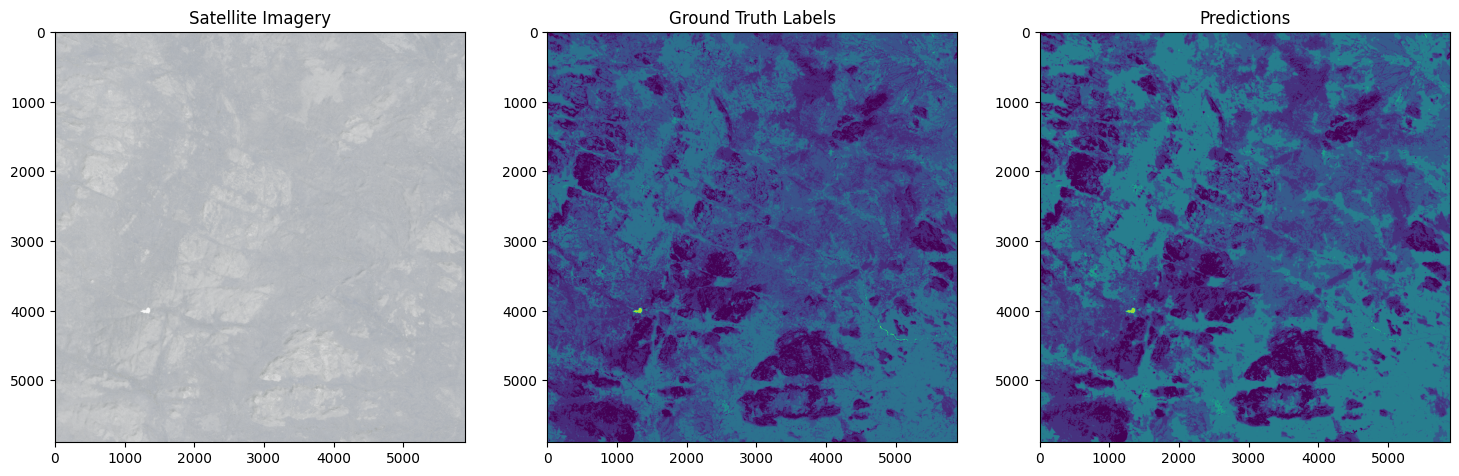

In [39]:
# Load the satellite imagery
satellite_image_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/GROUND_TRUTH_LC/RASTER_20.tif"
satellite_image = gdal.Open(satellite_image_path)
satellite_image_array = np.transpose(satellite_image.ReadAsArray(), (1, 2, 0))

# Load the ground truth labels
ground_truth_labels_path = "/content/drive/MyDrive/DEEP_LEARNING/16_GRID/LABEL_LC/RASTER_20.tif"
ground_truth_labels = gdal.Open(ground_truth_labels_path)
ground_truth_labels_array = ground_truth_labels.ReadAsArray()

# Convert the predicted image array to an RGB image
predicted_image_array_rgb = predicted_image_array.argmax(axis=-1)

# Plot Satellite Imagery, Ground Truth Labels, and Predictions together
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(satellite_image_array)
ax[0].set_title('Satellite Imagery')

ax[1].imshow(ground_truth_labels_array)
ax[1].set_title('Ground Truth Labels')

ax[2].imshow(predicted_image_array_rgb)
ax[2].set_title('Predictions')

plt.show()